In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import ModelClass
import matplotlib.pyplot as plt
import seaborn as sns

from sklearnex import patch_sklearn
patch_sklearn(verbose=False)
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#### Loading the Data

In [2]:
X = pd.read_csv('data/Training-set-values.csv')
y = pd.read_csv('data/Training-set-labels.csv')

X['date_recorded'] = pd.to_datetime(X['date_recorded']).astype(np.int64)

#### Preprocessors

In [3]:
# Super basic numeric transformer

numeric_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='median'))]
)

numeric_preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, make_column_selector(dtype_include=np.number)),
    ]
)

### Models

In [4]:
# kNearestNeighbors
kNearestNeighbors = {'classifier': KNeighborsClassifier(n_jobs=3), 'preprocessor': None}

# Logistic Regressoion
LogisticRegressionModel = {'classifier': LogisticRegression(C=1e6, n_jobs=3), 'preprocessor': None}

# Decision Trees
DecisionTrees = {'classifier': DecisionTreeClassifier(),'preprocessor': None}
# Decision Trees - adjusted
DecisionTreesAdjusted = {'classifier': DecisionTreeClassifier(criterion=['gini','entropy'], max_depth=[90,100], min_samples_split=[2,3], class_weight='balanced'),'preprocessor': numeric_preprocessor}

# Random Forest with numeric processor
RandomFM_1 = {'classifier': RandomForestClassifier(max_depth=20, min_samples_split=4, n_jobs=3), 'preprocessor': numeric_preprocessor}
# Random Forest no processor
RandomFM_2 = {'classifier': RandomForestClassifier(max_depth=20, min_samples_split=4, n_jobs=3), 'preprocessor': None}
# Random Forest default
# Included for RandomCVSearch later on
RandomFM_rs = {'classifier': RandomForestClassifier(n_jobs=3), 'preprocessor': None}

models = {'kNearestNeighbors': kNearestNeighbors,
    'LogisticRegression': LogisticRegressionModel,
    'DecisionTrees': DecisionTrees,
    'DecisionTreesAdjusted': DecisionTreesAdjusted,
    'RandomFM_1': RandomFM_1,
    'RandomFM_2': RandomFM_2,
    'RandomFM_rs': RandomFM_rs}


### Modeler

In [5]:
model_run = ModelClass.Modeler(models, X=X, y=y)

# Adding in after the model_run object is created so we can add onto the default preprocessor.
log_reg_regularized = {'classifier': LogisticRegression(n_jobs=3), 'preprocessor': model_run.create_default_prep(num_add=[('scaling', StandardScaler())])}
model_run.add_model('log_reg_regularized', log_reg_regularized)

### Search parameters and kwargs

In [6]:
kNN_params = dict(leaf_size=[1,50],
                    n_neighbors=[1,30], 
                    p=[1,2])
                    
LogRegRCV_params = dict(penalty=['l1', 'l2', 'elasticnet'],
                        C=stats.uniform(loc=1, scale=10),
                        max_iter=list(range(100,400)))

DecisionTree_params = dict(criterion=['gini', 'entropy'],
                        max_depth = list(range(20,50)),
                        min_samples_split = list(range(2, 10)))

RandForestRCV_params = dict(n_estimators=list(range(100,300)),
                            criterion=['gini', 'entropy'],
                            max_depth = list(range(20,50)),
                            min_samples_split = list(range(2, 10)))

search_options = {'n_jobs': 3, 'random_state': 9280210, 'n_iter': 20}

## Training LogisticRegression Model

In [7]:
model_run.train_model('LogisticRegression')

/home/thedefect/anaconda3/envs/learn-env/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:453: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
root - INFO - sklearn.linear_model.LogisticRegression.fit: fallback to original Scikit-learn
root - INFO - sklearn.linear_model.LogisticRegression.predict: fallback to original Scikit-learn
/home/thedefect/anaconda3/envs/learn-env/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:453: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the dat

## RandomizedSearchCV

In [8]:
model_run.hyper_search('kNearestNeighbors', params=kNN_params, searcher_kwargs=search_options, set_to_train=True)

/home/thedefect/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [9]:
model_run.hyper_search('log_reg_regularized', params=LogRegRCV_params, searcher_kwargs=search_options, set_to_train=True)

/home/thedefect/anaconda3/envs/learn-env/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:453: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
model_run.hyper_search('DecisionTrees', params=DecisionTree_params, searcher_kwargs=search_options, set_to_train=True)

In [11]:
model_run.hyper_search('DecisionTreesAdjusted', params=DecisionTree_params, searcher_kwargs=search_options, set_to_train=True)

In [12]:
model_run.hyper_search('RandomFM_1', params=RandForestRCV_params, searcher_kwargs=search_options, set_to_train=True)

In [13]:
model_run.hyper_search('RandomFM_2', params=RandForestRCV_params, searcher_kwargs=search_options, set_to_train=True)

In [14]:
model_run.hyper_search('RandomFM_rs', params=RandForestRCV_params, searcher_kwargs=search_options, set_to_train=True)

## Test Models

In [15]:
model_run.test_all()

## Plotting

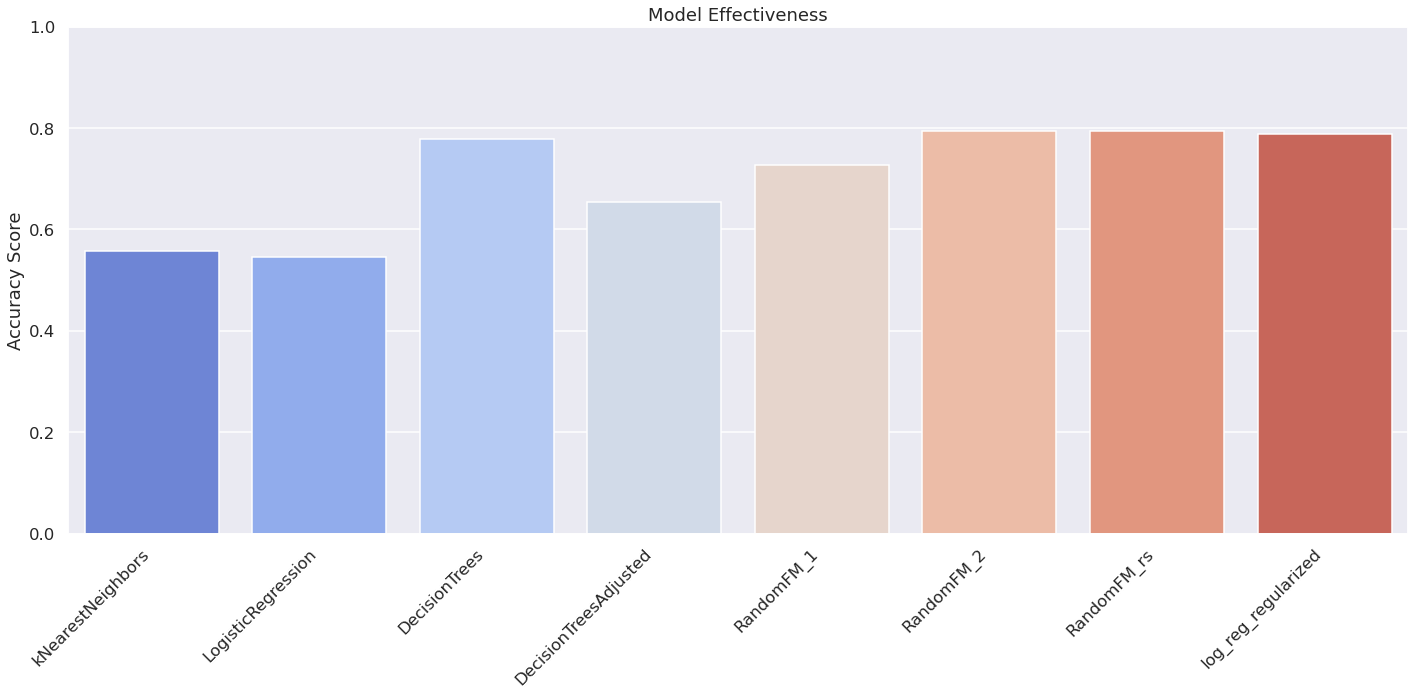

In [16]:
model_run.plot_models()

## Modeler

### Random Forests

root - INFO - sklearn.ensemble.RandomForestClassifier.predict: fallback to original Scikit-learn
root - INFO - sklearn.ensemble.RandomForestClassifier.predict_proba: fallback to original Scikit-learn


------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
Train Accuracy :  0.8774
Test Accuracy :  0.7942
------------------------------------------------------------

                         precision    recall  f1-score   support

             functional       0.75      0.95      0.84      8093
functional needs repair       0.78      0.15      0.25      1086
         non functional       0.89      0.69      0.78      5671

               accuracy                           0.79     14850
              macro avg       0.81      0.60      0.62     14850
           weighted avg       0.81      0.79      0.77     14850

------------------------------------------------------------




root - INFO - sklearn.ensemble.RandomForestClassifier.predict: fallback to original Scikit-learn
root - INFO - sklearn.ensemble.RandomForestClassifier.predict_proba: fallback to original Scikit-learn


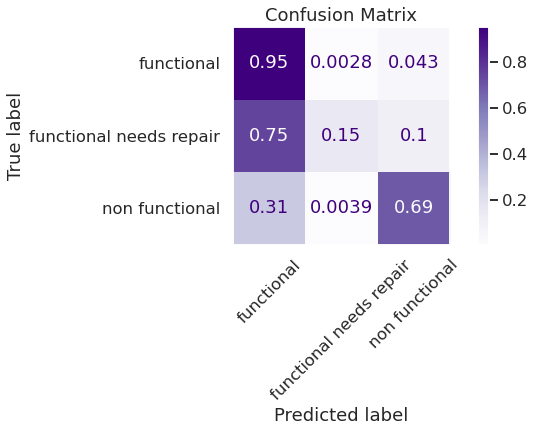

(<Figure size 720x288 with 2 Axes>,
 <AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>)

In [21]:
model_run.model_evaluation('RandomFM_rs')

root - INFO - sklearn.ensemble.RandomForestClassifier.predict: fallback to original Scikit-learn
root - INFO - sklearn.ensemble.RandomForestClassifier.predict_proba: fallback to original Scikit-learn
root - INFO - Model RandomFM_rs has permutation importances of quantity          0.023791
quantity_group    0.019832
lga               0.010694
funder            0.010296
payment           0.010242
region            0.009899
basin             0.009017
payment_type      0.008673
scheme_name       0.008431
installer         0.008411
dtype: float64


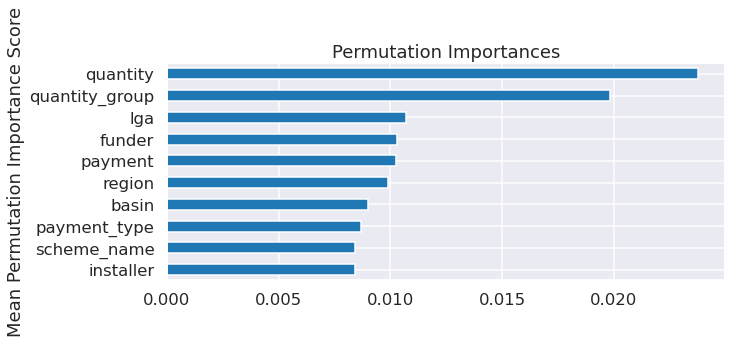

In [22]:
importance_kwargs = dict(n_repeats=10, n_jobs=3)
model_run.permutation_importance('RandomFM_rs', perm_kwargs=importance_kwargs)